## Derive an RE24 matrix and LWTS from PBP data

Following the methodology described here: https://library.fangraphs.com/the-beginners-guide-to-deriving-woba/

Basic steps:

1. Compute an RE24 table by grouping all events based on starting base-out state and looking at runs scored from those situations.
2. For each PA, add the starting RE, ending RE, and the change in RE.
3. Group all of that by event type to get an average run value for each event type.
4. Store off a PA data table, which includes RE and run value fields, to use in further analysis.

Now that we have this PA table, there are all sorts of things we could do next:
* Compute wOBA weights
* Aggregate run value or RE along various dimensions (e.g., on batter or pitcher)
* Create a model to predict run value of a particular PA (e.g., based on batter and pitcher stats)

In [1]:
import pandas as pd
import numpy as np
import pyretro.boxball_loader as bbl

In [2]:
YEARS = bbl.Seasons(2000, 2019)
cols = ['game_id', 'fate_runs_ct', 'event_runs_ct', 'outs_ct', 'event_outs_ct', 'start_bases_cd', 
        'inn_ct', 'bat_home_id', 'end_bases_cd', 'game_pa_ct', 'game_end_fl', 'pit_id', 'bat_id', 
        'bat_hand_cd', 'event_cd', 'resp_pit_hand_cd', 'resp_bat_hand_cd', 'tb_ct', 'ob_fl'
]


In [3]:
ev = bbl.load_event_data(seasons=YEARS, requested_columns=cols, pa_only=False, game_types=bbl.GameType.RS)


In [4]:
ev.columns

Index(['game_end_fl', 'resp_bat_hand_cd', 'event_cd', 'bat_id', 'inn_ct',
       'fate_runs_ct', 'h_fl', 'event_runs_ct', 'date', 'pit_id', 'outs_ct',
       'start_bases_cd', 'resp_pit_hand_cd', 'ob_fl', 'game_id',
       'end_bases_cd', 'yr', 'game_type', 'tb_ct', 'bat_home_id',
       'event_outs_ct', 'bat_event_fl', 'game_pa_ct', 'ab_fl', 'bat_hand_cd'],
      dtype='object')

In [5]:
# Add a couple columns for computing RE24
ev['runs_finish_ct']=ev['fate_runs_ct']+ev['event_runs_ct'] #total runs in remainder of inning
ev['end_outs_ct']=ev['outs_ct']+ev['event_outs_ct'] # outs at end of event

In [6]:
# Generate a basic RE24 table
re24 = ev.groupby(['start_bases_cd', 'outs_ct'])['runs_finish_ct'].mean().unstack()
re24[3] = re24[2]*0
re24 = re24.unstack()
re24

outs_ct  start_bases_cd
0        0                 0.511845
         1                 0.895798
         2                 1.142028
         3                 1.490203
         4                 1.416561
         5                 1.802290
         6                 2.007698
         7                 2.304029
1        0                 0.273873
         1                 0.535194
         2                 0.694084
         3                 0.926731
         4                 0.968167
         5                 1.184323
         6                 1.409886
         7                 1.573842
2        0                 0.105753
         1                 0.232675
         2                 0.330364
         3                 0.446338
         4                 0.369960
         5                 0.504265
         6                 0.586408
         7                 0.776616
3        0                 0.000000
         1                 0.000000
         2                 0.000000
    

In [7]:
def get_printable_re24table(re24):
    df = re24.reset_index()
    start_bases_txt = df['start_bases_cd'].apply(lambda x: ['___', '1__', '_2_', '12_', '__3', '1_3', '_23', '123'][int(x)])
    df['bases'] = start_bases_txt
    printable = df.rename(columns={0: 'run_exp', 'outs_ct': 'outs'}) \
        .set_index(['outs', 'bases']) \
        .unstack(level=0) \
        .sort_values(by=('start_bases_cd', 0))['run_exp']

    return printable.to_markdown()

print(get_printable_re24table(re24))

| bases   |        0 |        1 |        2 |   3 |
|:--------|---------:|---------:|---------:|----:|
| ___     | 0.511845 | 0.273873 | 0.105753 |   0 |
| 1__     | 0.895798 | 0.535194 | 0.232675 |   0 |
| _2_     | 1.14203  | 0.694084 | 0.330364 |   0 |
| 12_     | 1.4902   | 0.926731 | 0.446338 |   0 |
| __3     | 1.41656  | 0.968167 | 0.36996  |   0 |
| 1_3     | 1.80229  | 1.18432  | 0.504265 |   0 |
| _23     | 2.0077   | 1.40989  | 0.586408 |   0 |
| 123     | 2.30403  | 1.57384  | 0.776616 |   0 |


In [8]:
# What about probability of at least one run scored?
ev['score_left'] = np.where(ev['runs_finish_ct']>0, 1, 0)
ev.groupby(['start_bases_cd', 'outs_ct'])['score_left'].mean().unstack()

outs_ct                0         1         2
start_bases_cd                              
0               0.280065  0.164609  0.071551
1               0.425276  0.272984  0.130173
2               0.622033  0.406246  0.219737
3               0.623717  0.418679  0.228478
4               0.841254  0.658379  0.260029
5               0.857479  0.641596  0.277002
6               0.855245  0.682529  0.264072
7               0.863084  0.667894  0.325626

In [9]:
half_innings_ct = len(ev[['game_id', 'inn_ct', 'bat_home_id']].drop_duplicates())
half_innings_ct

870031

In [10]:
# Now compute the RE24 before/after each event
def add_REs_to_events(evs):
    # Add the re_start and re_end to each event (merge is faster than a lookup)
    e_s = pd.merge(left=evs, right=re24.rename('re_start'), on=['start_bases_cd', 'outs_ct'])
    e_e = pd.merge(left=e_s, right=re24.rename('re_end'), \
               left_on=['end_bases_cd', 'end_outs_ct'], \
               right_on=['start_bases_cd', 'outs_ct'])
    e_e['re_added'] = e_e['re_end'] - e_e['re_start'] + e_e['event_runs_ct']
    return e_e.sort_values(['game_id', 'inn_ct', 'bat_home_id', 'game_pa_ct'])

In [11]:
evs_re = add_REs_to_events(ev)
evs_re.head(20)

game_end_fl resp_bat_hand_cd  event_cd    bat_id  inn_ct  \
0              False                R        20  knobc001       1   
833867         False                R         6  jeted001       1   
1019924        False                R         2  jeted001       1   
2021622        False                L        14  oneip001       1   
2886491        False                L         2  willb002       1   
1              False                L        20  erstd001       1   
995410         False                L         2  kenna001       1   
2287332        False                L         3  vaugm001       1   
223832         False                L         2  martt002       2   
1019925        False                L         2  leder001       2   
2021623        False                L        14  posaj001       2   
2886492        False                R         2  spens001       2   
876641         False                R        23  salmt001       2   
223833         False                L         2  andeg001       2   
1602624        False                R        20  glaut001       2   
1484411        False                L         6  spies001       2   
2021624        False                L        14  spies001       2   
2886493        False                R         2  molib001       2   
223834         False                R         2  bross001       3   
1019926        False                R         2  knobc001       3   

         fate_runs_ct  h_fl  event_runs_ct       date    pit_id  ...  \
0                   0     1              0 2000-04-03  hillk001  ...   
833867              0     0              0 2000-04-03  hillk001  ...   
1019924             0     0              0 2000-04-03  hillk001  ...   
2021622             0     0              0 2000-04-03  hillk001  ...   
2886491             0     0              0 2000-04-03  hillk001  ...   
1                   0     1              0 2000-04-03  herno001  ...   
995410              0     0              0 2000-04-03  herno001  ...   
2287332             0     0              0 2000-04-03  herno001  ...   
223832              0     0              0 2000-04-03  hillk001  ...   
1019925             0     0              0 2000-04-03  hillk001  ...   
2021623             0     0              0 2000-04-03  hillk001  ...   
2886492             0     0              0 2000-04-03  hillk001  ...   
876641              0     1              1 2000-04-03  herno001  ...   
223833              0     0              0 2000-04-03  herno001  ...   
1602624             0     1              0 2000-04-03  herno001  ...   
1484411             0     0              0 2000-04-03  herno001  ...   
2021624             0     0              0 2000-04-03  herno001  ...   
2886493             0     0              0 2000-04-03  herno001  ...   
223834              0     0              0 2000-04-03  hillk001  ...   
1019926             0     0              0 2000-04-03  hillk001  ...   

         bat_event_fl  game_pa_ct  ab_fl  bat_hand_cd runs_finish_ct  \
0                True           0   True            R              0   
833867          False           1  False            R              0   
1019924          True           1   True            R              0   
2021622          True           2  False            L              0   
2886491          True           3   True            L              0   
1                True           0   True            L              0   
995410           True           1   True            L              0   
2287332          True           2   True            L              0   
223832           True           4   True            L              0   
1019925          True           5   True            L              0   
2021623          True           6  False            L              0   
2886492          True           7   True            R              0   
876641           True           3   True            R              1   
223833           True           4   Tr

In [12]:
# Just to sanity check, let's compute the sum by pitcher
evs_re.groupby('pit_id')['re_added'].sum().sort_values()

pit_id
kersc001   -497.396826
verlj001   -359.383667
greiz001   -318.304208
schem001   -307.146077
hallr001   -282.549795
               ...    
bellr003    116.979399
fossc001    122.495868
jacke001    129.999759
elars001    134.839591
limaj001    160.706315
Name: re_added, Length: 3308, dtype: float64

In [13]:
# What does total re_added sum to?
evs_re['re_added'].sum()

1981.093029445961

We might've expected the sum to come out to zero.  But it doesn't exactly, because RE24[0][0] isn't exactly equal to the the number of runs per inning.  This is because there are other [0][0] occurrences (e.g., after a leadoff HR) that are included in the re24[0][0] calculation.

In [14]:
# Now look at average RE change by event code
# This is the context-neutral run value of each event type
# Event code types are defined at:
# https://chadwick.sourceforge.net/doc/cwevent.html
event_res = evs_re.groupby('event_cd').agg({'re_added': np.mean})['re_added'].rename('event_re')
event_res

event_cd
2    -0.275641
3    -0.277177
4     0.179788
5     0.112313
6    -0.439913
8    -0.241722
9     0.261552
10    0.271777
11    0.265233
12   -0.425508
13    0.000000
14    0.311160
15    0.172917
16    0.333191
17    0.363501
18    0.499624
19   -0.203375
20    0.456639
21    0.762296
22    1.053653
23    1.391234
Name: event_re, dtype: float64

The last four event types are singles, doubles, triples and HR. Luckily those values look familiar (the same as computed by Pete Palmer back in 1982).

In [15]:
event_res.to_csv('~/temp/event_res.csv')

In [16]:
# Annotate each event with the context-neutral run value of the event type
evs_re = pd.merge(left=evs_re, right=event_res, on='event_cd') \
    .sort_values(['game_id', 'inn_ct', 'bat_home_id', 'game_pa_ct'])

evs_re.head(20)

game_end_fl resp_bat_hand_cd  event_cd    bat_id  inn_ct  \
0              False                R        20  knobc001       1   
568564         False                R         6  jeted001       1   
583539         False                R         2  jeted001       1   
2357271        False                L        14  oneip001       1   
583540         False                L         2  willb002       1   
1              False                L        20  erstd001       1   
583541         False                L         2  kenna001       1   
2647276        False                L         3  vaugm001       1   
583542         False                L         2  martt002       2   
583543         False                L         2  leder001       2   
2357272        False                L        14  posaj001       2   
583544         False                R         2  spens001       2   
3345955        False                R        23  salmt001       2   
583545         False                L         2  andeg001       2   
2              False                R        20  glaut001       2   
568565         False                L         6  spies001       2   
2357273        False                L        14  spies001       2   
583546         False                R         2  molib001       2   
583547         False                R         2  bross001       3   
583548         False                R         2  knobc001       3   

         fate_runs_ct  h_fl  event_runs_ct       date    pit_id  ...  \
0                   0     1              0 2000-04-03  hillk001  ...   
568564              0     0              0 2000-04-03  hillk001  ...   
583539              0     0              0 2000-04-03  hillk001  ...   
2357271             0     0              0 2000-04-03  hillk001  ...   
583540              0     0              0 2000-04-03  hillk001  ...   
1                   0     1              0 2000-04-03  herno001  ...   
583541              0     0              0 2000-04-03  herno001  ...   
2647276             0     0              0 2000-04-03  herno001  ...   
583542              0     0              0 2000-04-03  hillk001  ...   
583543              0     0              0 2000-04-03  hillk001  ...   
2357272             0     0              0 2000-04-03  hillk001  ...   
583544              0     0              0 2000-04-03  hillk001  ...   
3345955             0     1              1 2000-04-03  herno001  ...   
583545              0     0              0 2000-04-03  herno001  ...   
2                   0     1              0 2000-04-03  herno001  ...   
568565              0     0              0 2000-04-03  herno001  ...   
2357273             0     0              0 2000-04-03  herno001  ...   
583546              0     0              0 2000-04-03  herno001  ...   
583547              0     0              0 2000-04-03  hillk001  ...   
583548              0     0              0 2000-04-03  hillk001  ...   

         game_pa_ct  ab_fl bat_hand_cd  runs_finish_ct end_outs_ct  \
0                 0   True           R               0           0   
568564            1  False           R               0           1   
583539            1   True           R               0           2   
2357271           2  False           L               0           2   
583540            3   True           L               0           3   
1                 0   True           L               0           0   
583541            1   True           L               0           2   
2647276           2   True           L               0           3   
583542            4   True           L               0           1   
583543            5   True           L               0           2   
2357272           6  False           L               0           2   
583544            7   True           R               0           3   
3345955           3   True           R               1           0   
583545            4   True           L               0           1

In [17]:
evs_re.to_parquet('~/temp/evs_re.parquet')

In [18]:
# Let's repeat the sanity check, let's compute the sum by pitcher
# Should see the context-sensitive and context-neutral match up
evs_re.groupby('pit_id')[['re_added', 'event_re']].sum().sort_values(by='re_added')

re_added    event_re
pit_id                          
kersc001 -497.396826 -502.056434
verlj001 -359.383667 -413.892537
greiz001 -318.304208 -303.263205
schem001 -307.146077 -330.554888
hallr001 -282.549795 -296.077490
...              ...         ...
bellr003  116.979399  111.851813
fossc001  122.495868   97.497858
jacke001  129.999759  139.941650
elars001  134.839591  118.936062
limaj001  160.706315  152.637884

[3308 rows x 2 columns]

In [19]:
# Now repeat for batters
# Should see the context-sensitive and context-neutral match up
evs_re.groupby('bat_id')[['re_added', 'event_re']].sum().sort_values(by='re_added')

re_added    event_re
bat_id                          
iztuc001 -231.810374 -197.145152
escoa003 -220.947632 -204.352520
mathj001 -182.115229 -202.343853
ausmb001 -179.328295 -127.378884
gonza002 -167.596345 -136.073642
...              ...         ...
rodra001  619.510561  603.802100
heltt001  620.900657  583.663519
ortid001  643.251558  579.600868
cabrm001  659.192770  633.466592
pujoa001  724.508915  731.849252

[4597 rows x 2 columns]

In [20]:
# We'll start simple: consider only uBB, HBP, 1B, 2B, 3B, HR; ignore IBB and Interference; everything else is an "out"

# First the positives
success_cols = [14, 16, 20, 21, 22, 23]
ignore_cols = [15, 17]
success_weights = evs_re.query('event_cd in @success_cols').groupby('event_cd') \
    .agg({'re_added': [len, np.mean]})['re_added'] \
    .rename(columns={'len': 'ct', 'mean': 're_added'})

success_weights

ct  re_added
event_cd                  
14        290005  0.311160
16         34246  0.333191
20        568564  0.456639
21        172299  0.762296
22         17797  1.053653
23        104079  1.391234

In [21]:
# Now do the same for outs (all as one big category)
out_weights = evs_re.query('event_cd not in @success_cols and event_cd not in @ignore_cols') \
    .agg({'re_added': [len, np.mean]}) \
    .rename(columns={'re_added': 'out'}) \
    .T.rename(columns={'len': 'ct', 'mean': 're_added'})
out_weights

ct  re_added
out  2635862.0 -0.249782

In [22]:
weights = pd.concat([success_weights, out_weights])
weights

ct  re_added
14    290005.0  0.311160
16     34246.0  0.333191
20    568564.0  0.456639
21    172299.0  0.762296
22     17797.0  1.053653
23    104079.0  1.391234
out  2635862.0 -0.249782

In [23]:
OUT_VALUE=out_weights['re_added'][0]
OUT_VALUE

-0.24978246841998006

In [24]:
# wOBA weights are based on the value vs. an out (rather than vs. neutral)
weights['re_over_out'] = weights['re_added']-OUT_VALUE
weights

ct  re_added  re_over_out
14    290005.0  0.311160     0.560942
16     34246.0  0.333191     0.582973
20    568564.0  0.456639     0.706421
21    172299.0  0.762296     1.012079
22     17797.0  1.053653     1.303435
23    104079.0  1.391234     1.641017
out  2635862.0 -0.249782     0.000000

In [25]:
raw_woba = sum(weights['ct']*weights['re_over_out'])/sum(weights['ct'])
raw_woba

0.24920109558596654

In [26]:
target_woba = .315
woba_scale = target_woba/raw_woba
weights['woba_wt'] = weights['re_over_out']*woba_scale
weights, woba_scale

(            ct  re_added  re_over_out   woba_wt
 14    290005.0  0.311160     0.560942  0.709053
 16     34246.0  0.333191     0.582973  0.736901
 20    568564.0  0.456639     0.706421  0.892944
 21    172299.0  0.762296     1.012079  1.279308
 22     17797.0  1.053653     1.303435  1.647593
 23    104079.0  1.391234     1.641017  2.074310
 out  2635862.0 -0.249782     0.000000  0.000000,
 1.2640393865818094)

OK, so that gives us wOBA weights!

## Modeling individual PAs

### Measure outcome: run value based on event code
### Batter estimate (wOBA)
### Pitcher estimate (wOBA allowed)
### Regression or other model

In [29]:
pa = evs_re

In [30]:
batters = pa.groupby('bat_id')['event_re'].mean().rename('bat_re_avg')
batters

bat_id
aardd001   -0.276255
abada001   -0.123478
abadf001   -0.195130
abboj002   -0.003290
abbok002   -0.033651
              ...   
zobrb001    0.015586
zoccp001   -0.135768
zoske001   -0.276025
zulej001    0.006954
zunim001   -0.028183
Name: bat_re_avg, Length: 4597, dtype: float64

In [31]:
pitchers = pa.groupby('pit_id')['event_re'].mean().rename('pit_re_avg')
pitchers

pit_id
aardd001   -0.002590
abadf001   -0.010613
abbop001    0.013814
abreb002   -0.111076
abrej002    0.041484
              ...   
zinkc001    0.124365
zitob001   -0.009095
zobrb001   -0.041228
zumaj001   -0.021079
zycht001   -0.036135
Name: pit_re_avg, Length: 3308, dtype: float64

In [32]:
pa = pd.merge(left=pa, right=batters, on='bat_id')
pa = pd.merge(left=pa, right=pitchers, on='pit_id')

In [33]:
pa = pa.sort_values(['game_id', 'inn_ct', 'bat_home_id', 'game_pa_ct'])
pa

game_end_fl resp_bat_hand_cd  event_cd    bat_id  inn_ct  \
0              False                R        20  knobc001       1   
3              False                R         6  jeted001       1   
4              False                R         2  jeted001       1   
7              False                L        14  oneip001       1   
10             False                L         2  willb002       1   
...              ...              ...       ...       ...     ...   
1467637        False                L         3  steva001       8   
1467771        False                R         2  barrt004       8   
3780150        False                L        14  bauej001       9   
3780146        False                R         2  merco003       9   
3780151         True                R         2  haase001       9   

         fate_runs_ct  h_fl  event_runs_ct       date    pit_id  ...  \
0                   0     1              0 2000-04-03  hillk001  ...   
3                   0     0              0 2000-04-03  hillk001  ...   
4                   0     0              0 2000-04-03  hillk001  ...   
7                   0     0              0 2000-04-03  hillk001  ...   
10                  0     0              0 2000-04-03  hillk001  ...   
...               ...   ...            ...        ...       ...  ...   
1467637             0     0              0 2019-09-29  carrc003  ...   
1467771             0     0              0 2019-09-29  carrc003  ...   
3780150             0     0              0 2019-09-29  fedde001  ...   
3780146             0     0              0 2019-09-29  fedde001  ...   
3780151             0     0              0 2019-09-29  fedde001  ...   

         bat_hand_cd  runs_finish_ct end_outs_ct  score_left  re_start  \
0                  R               0           0           0  0.511845   
3                  R               0           1           0  0.895798   
4                  R               0           2           0  0.273873   
7                  L               0           2           0  0.105753   
10                 L               0           3           0  0.232675   
...              ...             ...         ...         ...       ...   
1467637            L               0           2           0  1.184323   
1467771            R               0           3           0  0.504265   
3780150            L               0           0           0  0.511845   
3780146            R               0           2           0  0.895798   
3780151            R               0           3           0  0.105753   

           re_end  re_added  event_re  bat_re_avg  pit_re_avg  
0        0.895798  0.383953  0.456639   -0.012795    0.075442  
3        0.273873 -0.621925 -0.439913    0.028679    0.075442  
4        0.105753 -0.168120 -0.275641    0.028679    0.075442  
7        0.232675  0.126922  0.311160    0.008335    0.075442  
10       0.000000 -0.232675 -0.275641    0.034834    0.075442  
...           ...       ...       ...         ...         ...  
1467637  0.504265 -0.680058 -0.277177   -0.034725   -0.016143  
1467771  0.000000 -0.504265 -0.275641   -0.275641   -0.016143  
3780150  0.895798  0.383953  0.311160   -0.019489    0.026597  
3780146  0.105753 -0.790045 -0.275641    0.002606    0.026597  
3780151  0.000000 -0.105753 -0.275641   -0.137277    0.026597  

[3846591 rows x 34 columns]

In [34]:
pa['handedness'] = pa['resp_pit_hand_cd']+pa['resp_bat_hand_cd']
pa['handedness'].sample(10)

1542767    RR
151094     RL
2759054    LL
3483258    RL
2014732    RR
1795117    RL
948864     LL
752781     RR
500957     RL
881949     LL
Name: handedness, dtype: object

In [35]:
import statsmodels.api as sm

In [36]:
X = pd.concat([pa[['bat_re_avg', 'pit_re_avg']], pd.get_dummies(pa['handedness'])], axis=1)
y = pa['event_re']
#X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               event_re   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     7493.
Date:                Sun, 28 Jan 2024   Prob (F-statistic):               0.00
Time:                        16:10:00   Log-Likelihood:            -2.0967e+06
No. Observations:             3846591   AIC:                         4.193e+06
Df Residuals:                 3846584   BIC:                         4.193e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
bat_re_avg     1.0057      0.006    181.584      0.000       0.995       1.017
pit_re_avg     0.9938      0.010    101.201      0.000       0.975       1.013
B?            -0.2637      0.417     -0.632      0.527      -1.082       0.554
LL            -0.0251      0.001    -32.591      0.000      -0.027      -0.024
LR             0.0095      0.000     19.579      0.000       0.009       0.010
RL             0.0052      0.000     14.478      0.000       0.005       0.006
RR            -0.0058      0.000    -16.963      0.000      -0.006      -0.005
==============================================================================
Omnibus:                   801911.031   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1432889.576
Skew:                           1.354   Prob(JB):                         0.00
Kurtosis:                       4.268   Cond. No.                     1.22e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.22e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [37]:
predictions

0          0.056282
3          0.097991
4          0.097991
7          0.088595
10         0.115244
             ...   
1467637   -0.045724
1467771   -0.299069
3780150    0.012072
3780146    0.023230
3780151   -0.117446
Length: 3846591, dtype: float64

In [38]:
pa['re_predicted']=predictions

In [39]:
pa.groupby('bat_id')['re_predicted'].sum().sort_values()

bat_id
escoa003   -240.661488
mathj001   -215.715585
iztuc001   -149.824116
haraa001   -144.716981
hecha001   -140.952724
               ...    
bondb001    596.957968
berkl001    607.104292
cabrm001    610.315116
rodra001    611.300286
pujoa001    718.819280
Name: re_predicted, Length: 4597, dtype: float64

In [40]:
pd.get_dummies(pa['handedness'])

B?  LL  LR  RL  RR
0         0   0   0   0   1
3         0   0   0   0   1
4         0   0   0   0   1
7         0   0   0   1   0
10        0   0   0   1   0
...      ..  ..  ..  ..  ..
1467637   0   0   0   1   0
1467771   0   0   0   0   1
3780150   0   0   0   1   0
3780146   0   0   0   0   1
3780151   0   0   0   0   1

[3846591 rows x 5 columns]

In [41]:
pa.to_parquet('../data/mine/pa2015-2020.parquet')

OK, so now we can predict individual PAs.  The r^2 is very low (.013) because of the variability of PAs.  How about if we look at cohorts?

In [42]:
# make 20 buckets, bucketing *the PA*.  So each bucket will have the same number of PA, not batters
bat_buckets = pd.qcut(pa.bat_re_avg, q=20).rename('bat_bucket')
bat_buckets

0          (-0.0128, -0.00938]
3             (0.0262, 0.0312]
4             (0.0262, 0.0312]
7            (0.00675, 0.0096]
10            (0.0312, 0.0377]
                  ...         
1467637      (-0.0512, -0.033]
1467771       (-0.36, -0.0512]
3780150     (-0.0247, -0.0185]
3780146     (0.00143, 0.00446]
3780151       (-0.36, -0.0512]
Name: bat_bucket, Length: 3846591, dtype: category
Categories (20, interval[float64, right]): [(-0.36, -0.0512] < (-0.0512, -0.033] < (-0.033, -0.0247] < (-0.0247, -0.0185] ... (0.0262, 0.0312] < (0.0312, 0.0377] < (0.0377, 0.0489] < (0.0489, 1.054]]

In [43]:
# make 20 buckets, bucketing *the PA*.  So each bucket will have the same number of PA, not pitchers
pit_buckets = pd.qcut(pa.pit_re_avg, q=20).rename('pit_bucket')
pit_buckets

0             (0.0344, 0.851]
3             (0.0344, 0.851]
4             (0.0344, 0.851]
7             (0.0344, 0.851]
10            (0.0344, 0.851]
                  ...        
1467637    (-0.0194, -0.0158]
1467771    (-0.0194, -0.0158]
3780150      (0.0242, 0.0344]
3780146      (0.0242, 0.0344]
3780151      (0.0242, 0.0344]
Name: pit_bucket, Length: 3846591, dtype: category
Categories (20, interval[float64, right]): [(-0.278, -0.0321] < (-0.0321, -0.0244] < (-0.0244, -0.0194] < (-0.0194, -0.0158] ... (0.0152, 0.0184] < (0.0184, 0.0242] < (0.0242, 0.0344] < (0.0344, 0.851]]

In [44]:
pa.groupby(bat_buckets)['bat_re_avg'].mean()

bat_bucket
(-0.36, -0.0512]       -0.118558
(-0.0512, -0.033]      -0.039634
(-0.033, -0.0247]      -0.028240
(-0.0247, -0.0185]     -0.021383
(-0.0185, -0.0128]     -0.015272
(-0.0128, -0.00938]    -0.010844
(-0.00938, -0.00505]   -0.007215
(-0.00505, -0.00128]   -0.003178
(-0.00128, 0.00143]    -0.000115
(0.00143, 0.00446]      0.003037
(0.00446, 0.00675]      0.005592
(0.00675, 0.0096]       0.008295
(0.0096, 0.013]         0.011306
(0.013, 0.016]          0.014718
(0.016, 0.0212]         0.018890
(0.0212, 0.0262]        0.023543
(0.0262, 0.0312]        0.028531
(0.0312, 0.0377]        0.034165
(0.0377, 0.0489]        0.043697
(0.0489, 1.054]         0.063822
Name: bat_re_avg, dtype: float64

In [45]:
summarize_stats(pa, bat_buckets)

NameError: name 'summarize_stats' is not defined

In [ ]:
summarize_stats(pa, pit_buckets)

pa     ob      ab      h       tb        ba  \
pit_bucket                                                             
(-0.278, -0.0321]    193834  52255  175348  37185  59030.0  0.212064   
(-0.0321, -0.0244]   179385  51693  161912  37623  58627.0  0.232367   
(-0.0244, -0.0194]   191436  56556  172739  41621  64651.0  0.240947   
(-0.0194, -0.0158]   182206  54277  163276  39196  62293.0  0.240060   
(-0.0158, -0.0127]   184954  56013  165777  40274  64100.0  0.242941   
(-0.0127, -0.00911]  185439  56678  166197  41374  65317.0  0.248946   
(-0.00911, -0.0061]  185815  57975  165532  41547  65620.0  0.250991   
(-0.0061, -0.0041]   187670  58569  168184  42759  68004.0  0.254239   
(-0.0041, -0.0022]   189654  59450  170392  43872  70532.0  0.257477   
(-0.0022, 0.000188]  182738  57977  163512  42423  68105.0  0.259449   
(0.000188, 0.00236]  187501  59909  168471  44608  70669.0  0.264781   
(0.00236, 0.00413]   187939  60444  167831  44332  71009.0  0.264147   
(0.00413, 0.0066]    185995  60449  165335  43791  70055.0  0.264862   
(0.0066, 0.00913]    186575  60923  165820  44384  71490.0  0.267664   
(0.00913, 0.012]     186123  61601  165097  44867  71820.0  0.271761   
(0.012, 0.0152]      184601  61619  163865  44955  72072.0  0.274342   
(0.0152, 0.0184]     186389  62685  165217  45768  73795.0  0.277017   
(0.0184, 0.0242]     187093  63933  165385  46540  75141.0  0.281404   
(0.0242, 0.0344]     185426  64541  163018  46427  76568.0  0.284797   
(0.0344, 0.851]      185701  69443  161002  49193  83971.0  0.305543   

                          obp       slg      woba  
pit_bucket                                         
(-0.278, -0.0321]    0.269586  0.336645  0.261643  
(-0.0321, -0.0244]   0.288168  0.362092  0.279174  
(-0.0244, -0.0194]   0.295430  0.374270  0.286690  
(-0.0194, -0.0158]   0.297888  0.381520  0.290439  
(-0.0158, -0.0127]   0.302848  0.386664  0.295104  
(-0.0127, -0.00911]  0.305642  0.393010  0.298032  
(-0.00911, -0.0061]  0.312004  0.396419  0.302736  
(-0.0061, -0.0041]   0.312085  0.404343  0.305310  
(-0.0041, -0.0022]   0.313466  0.413940  0.309077  
(-0.0022, 0.000188]  0.317268  0.416514  0.311867  
(0.000188, 0.00236]  0.319513  0.419473  0.313790  
(0.00236, 0.00413]   0.321615  0.423098  0.316035  
(0.00413, 0.0066]    0.325003  0.423715  0.318070  
(0.0066, 0.00913]    0.326534  0.431130  0.321043  
(0.00913, 0.012]     0.330969  0.435017  0.324491  
(0.012, 0.0152]      0.333796  0.439825  0.327640  
(0.0152, 0.0184]     0.336313  0.446655  0.331016  
(0.0184, 0.0242]     0.341718  0.454340  0.336248  
(0.0242, 0.0344]     0.348069  0.469690  0.344549  
(0.0344, 0.851]      0.373951  0.521553  0.374191

In [ ]:
bucketed = pa.groupby([bat_buckets, pit_buckets])[['bat_re_avg', 'pit_re_avg', 'event_re']].mean()
bucketed

bat_re_avg  pit_re_avg  event_re
bat_bucket       pit_bucket                                          
(-0.36, -0.0512] (-0.278, -0.0321]    -0.105207   -0.042749 -0.134285
                 (-0.0321, -0.0244]   -0.115340   -0.027478 -0.135527
                 (-0.0244, -0.0194]   -0.118691   -0.021534 -0.134187
                 (-0.0194, -0.0158]   -0.119748   -0.017660 -0.134749
                 (-0.0158, -0.0127]   -0.111426   -0.014422 -0.121562
...                                         ...         ...       ...
(0.0489, 1.054]  (0.012, 0.0152]       0.064190    0.013509  0.082268
                 (0.0152, 0.0184]      0.064017    0.016916  0.082957
                 (0.0184, 0.0242]      0.064584    0.020805  0.095871
                 (0.0242, 0.0344]      0.064113    0.028520  0.096495
                 (0.0344, 0.851]       0.064647    0.052627  0.115915

[400 rows x 3 columns]

In [ ]:
X = bucketed[['bat_re_avg', 'pit_re_avg']]
y = bucketed['event_re']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               event_re   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                 1.234e+04
Date:                Wed, 25 May 2022   Prob (F-statistic):               0.00
Time:                        20:16:30   Log-Likelihood:                 1531.4
No. Observations:                 400   AIC:                            -3057.
Df Residuals:                     397   BIC:                            -3045.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.000     -1.995      0.047      -0.001    -7.8e-06
bat_re_avg     0.9937      0.007    137.117      0.000       0.979       1.008
pit_re_avg     0.9908      0.013     77.122      0.000       0.966       1.016
==============================================================================
Omnibus:                       14.287   Durbin-Watson:                   1.693
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               26.289
Skew:                          -0.184   Prob(JB):                     1.96e-06
Kurtosis:                       4.201   Cond. No.                         48.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This is great!  This gives basically the same prediction model as when we went PA-by-PA (very similar coefficients), but now with an r^2 of .96.  I think this shows that the model is good, but the PA-by-PA evaluation is necessarily going to show low r^2 due to variation.

In [ ]:
model

### Umpires

In [ ]:
gms.columns.values

array(['date', 'double_header', 'day_of_week', 'visiting_team',
       'visiting_team_league', 'visiting_team_game_number', 'home_team',
       'home_team_league', 'home_team_game_number', 'visitor_runs_scored',
       'home_runs_scored', 'length_in_outs', 'day_night',
       'completion_info', 'forfeit_info', 'protest_info', 'park_id',
       'attendance', 'duration', 'visitor_line_score', 'home_line_score',
       'visitor_ab', 'visitor_h', 'visitor_d', 'visitor_t', 'visitor_hr',
       'visitor_rbi', 'visitor_sh', 'visitor_sf', 'visitor_hbp',
       'visitor_bb', 'visitor_ibb', 'visitor_k', 'visitor_sb',
       'visitor_cs', 'visitor_gdp', 'visitor_ci', 'visitor_lob',
       'visitor_pitchers', 'visitor_er', 'visitor_ter', 'visitor_wp',
       'visitor_balks', 'visitor_po', 'visitor_a', 'visitor_e',
       'visitor_passed', 'visitor_db', 'visitor_tp', 'home_ab', 'home_h',
       'home_d', 'home_t', 'home_hr', 'home_rbi', 'home_sh', 'home_sf',
       'home_hbp', 'home_bb', 'home_ibb'

In [ ]:
gms[['game_id', 'umpire_h_id']]

game_id umpire_h_id
9728  NYN200003290    marsr901
9729  CHN200003300    herna901
9732  FLO200004030    demud901
9739  OAK200004030    monte901
9738  MIN200004030    reedr901
...            ...         ...
8931  PHI201909290    millb901
8930  NYN201909290    porta901
8929  COL201909290    gibsh902
8928  ARI201909290    muchm901
8936  ANA201909290    marqa901

[48588 rows x 2 columns]

In [ ]:
pa_w_ump = pd.merge(left=pa, right=gms[['game_id', 'umpire_h_id']], on='game_id')
pa_w_ump

game_id       date game_type resp_pit_hand_cd  event_cd  \
0        ANA200004030 2000-04-03        RS                R        20   
1        ANA200004030 2000-04-03        RS                R         6   
2        ANA200004030 2000-04-03        RS                R         2   
3        ANA200004030 2000-04-03        RS                R        14   
4        ANA200004030 2000-04-03        RS                R         2   
...               ...        ...       ...              ...       ...   
3846589  WAS201909290 2019-09-29        RS                R         3   
3846590  WAS201909290 2019-09-29        RS                R         2   
3846591  WAS201909290 2019-09-29        RS                R        14   
3846592  WAS201909290 2019-09-29        RS                R         2   
3846593  WAS201909290 2019-09-29        RS                R         2   

           bat_id  event_outs_ct  ab_fl  game_pa_ct  end_bases_cd  ...  \
0        knobc001              0   True           0             1  ...   
1        jeted001              1  False           1             0  ...   
2        jeted001              1   True           1             0  ...   
3        oneip001              0  False           2             1  ...   
4        willb002              1   True           3             1  ...   
...           ...            ...    ...         ...           ...  ...   
3846589  steva001              1   True          37             5  ...   
3846590  barrt004              1   True          38             5  ...   
3846591  bauej001              0  False          33             1  ...   
3846592  merco003              2   True          34             0  ...   
3846593  haase001              1   True          35             0  ...   

        score_left  re_start    re_end  re_added  event_re  bat_re_avg  \
0                0  0.511845  0.895798  0.383953  0.456638   -0.012795   
1                0  0.895798  0.273873 -0.621926 -0.439912    0.028679   
2                0  0.273873  0.105753 -0.168120 -0.275642    0.028679   
3                0  0.105753  0.232675  0.126923  0.311160    0.008335   
4                0  0.232675  0.000000 -0.232675 -0.275642    0.034834   
...            ...       ...       ...       ...       ...         ...   
3846589          0  1.184296  0.504265 -0.680031 -0.277176   -0.034725   
3846590          0  0.504265  0.000000 -0.504265 -0.275642   -0.275642   
3846591          0  0.511845  0.895798  0.383953  0.311160   -0.019489   
3846592          0  0.895798  0.105753 -0.790045 -0.275642    0.002606   
3846593          0  0.105753  0.000000 -0.105753 -0.275642   -0.137277   

        pit_re_avg  handedness  re_predicted  umpire_h_id  
0         0.075442          RR      0.056282     mcclt901  
1         0.075442          RR      0.097992     mcclt901  
2         0.075442          RR      0.097992     mcclt901  
3         0.075442          RL      0.088595     mcclt901  
4         0.075442          RL      0.115244     mcclt901  
...            ...         ...           ...          ...  
3846589  -0.016142          RL     -0.045723     blasc901  
3846590  -0.016142          RR     -0.299068     blasc901  
3846591   0.026599          RL      0.012074     blasc901  
3846592   0.026599          RR      0.023232     blasc901  
3846593   0.026599          RR     -0.117444     blasc901  

[3846594 rows x 37 columns]

In [ ]:
summarize_stats(pa_w_ump, 'umpire_h_id')

pa     ob     ab      h     tb        ba       obp       slg  \
umpire_h_id                                                                    
addir901      3336   1026   2968    722   1217  0.243261  0.307554  0.410040   
armer901       910    282    817    208    323  0.254590  0.309890  0.395349   
aschd901       615    202    547    150    242  0.274223  0.328455  0.442413   
bacoj901       467    150    426    115    203  0.269953  0.321199  0.476526   
bakej902     17315   5456  15449   3905   6363  0.252767  0.315103  0.411871   
...            ...    ...    ...    ...    ...       ...       ...       ...   
wintm901     47622  15251  42486  11096  17627  0.261168  0.320251  0.414890   
wolcq901     14267   4559  12789   3329   5352  0.260302  0.319549  0.418485   
wolfj901     46327  14795  41459  10903  17428  0.262983  0.319360  0.420367   
woodt901      7923   2539   7085   1834   3088  0.258857  0.320459  0.435850   
younl901     19204   6284  16990   4520   7336  0.266039  0.327223  0.431783   

                 woba  
umpire_h_id            
addir901     0.305432  
armer901     0.300873  
aschd901     0.324950  
bacoj901     0.334604  
bakej902     0.309811  
...               ...  
wintm901     0.312839  
wolcq901     0.314121  
wolfj901     0.313960  
woodt901     0.320560  
younl901     0.321625  

[170 rows x 9 columns]

In [ ]:
ump_stats = pa_w_ump.groupby('umpire_h_id').agg({'bat_event_fl': len, 're_predicted': np.mean , 'event_re': np.mean}).rename(columns={'bat_event_fl': 'pa'})
ump_stats

pa  re_predicted  event_re
umpire_h_id                               
addir901      3442     -0.003735 -0.005047
armer901       943      0.002429 -0.007897
aschd901       641      0.004694  0.010541
bacoj901       478     -0.001500  0.014321
bakej902     17845     -0.006979 -0.002927
...            ...           ...       ...
wintm901     49182      0.001489  0.001300
wolcq901     14725     -0.006359  0.001595
wolfj901     47786      0.000842  0.001931
woodt901      8145     -0.004938  0.004561
younl901     19795      0.007696  0.009285

[170 rows x 3 columns]

<AxesSubplot:xlabel='re_predicted', ylabel='event_re'>

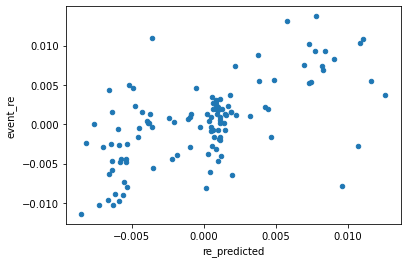

In [ ]:
ump_stats.loc[ump_stats['pa']>6000].plot.scatter(x='re_predicted', y='event_re')

<AxesSubplot:xlabel='umpire_h_id'>

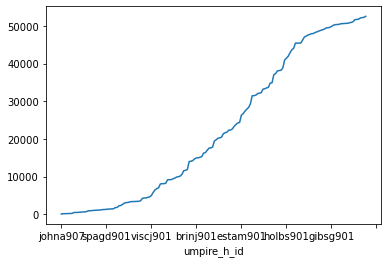

In [ ]:
ump_stats.sort_values(by='pa').pa.plot()

In [ ]:
ump_stats['re_effect_obs'] = ump_stats['event_re']-ump_stats['re_predicted']
ump_stats.sort_values(by='pa')

pa  re_predicted  event_re  re_effect_obs
umpire_h_id                                              
johna907        81     -0.017033  0.003564       0.020597
lollm901       161     -0.013334 -0.022853      -0.009519
gosnj901       164     -0.006834  0.005093       0.011927
rakos901       184     -0.018237 -0.027676      -0.009438
byrnj902       216     -0.013595 -0.035038      -0.021444
...            ...           ...       ...            ...
diazl901     51830      0.001113 -0.001620      -0.002733
millb901     52146      0.000399 -0.006074      -0.006474
herna901     52253      0.000732 -0.001684      -0.002416
timmt901     52312      0.001086  0.003156       0.002070
mealj901     52592     -0.000242 -0.000403      -0.000162

[170 rows x 4 columns]

<AxesSubplot:>

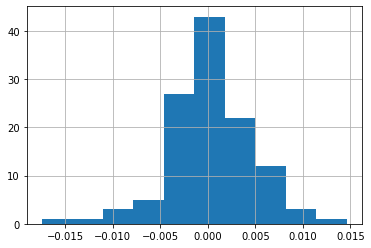

In [ ]:
ump_stats.loc[ump_stats['pa']>6000].re_effect_obs.hist()

In [ ]:
ump_stats.loc[ump_stats['pa']>6000].sort_values(by='re_effect_obs')

pa  re_predicted  event_re  re_effect_obs
umpire_h_id                                              
hirsm901      8064      0.009609 -0.007839      -0.017447
craft901     11700      0.010690 -0.002734      -0.013424
shulj901      6836      0.012592  0.003727      -0.008865
hirsj901     32069      0.001944 -0.006446      -0.008390
eddid901     51154      0.000118 -0.008098      -0.008216
...            ...           ...       ...            ...
wolcq901     14725     -0.006359  0.001595       0.007955
woodt901      8145     -0.004938  0.004561       0.009498
lentn901      9205     -0.005192  0.004979       0.010171
rackd901     16373     -0.006595  0.004384       0.010979
torrc901     10144     -0.003604  0.010994       0.014597

[118 rows x 4 columns]